In [1]:
%matplotlib inline


# OT for domain adaptation

This example introduces a domain adaptation in a 2D setting and the 4 OTDA
approaches currently supported in POT.


In [2]:
# Authors: Remi Flamary <remi.flamary@unice.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#
# License: MIT License

import matplotlib.pylab as pl
import ot
import numpy as np
import time
import seaborn as sns

## Generate data



In [3]:
n_source_samples = 250
n_target_samples = 250
# x[y == 1, 0] = -1.
# x[y == 1, 1] = -1.
# x[y == 2, 0] = -1.
# x[y == 2, 1] = 1.
# x[y == 3, 0] = 1.
# x[y == 3, 1] = 0
# x[y != 3, :] += 1.5 * nz * generator.randn(sum(y != 3), 2)
# x[y == 3, :] += 2 * nz * generator.randn(sum(y == 3), 2)

Xs, ys = ot.datasets.make_data_classif('3gauss', n_source_samples, nz=0.25) 
# class1: (0, -1) + 1.5*noise*gassian
# class2: (-1, 1) + 1.5*noise*gassian
# class3: (1,  0) + 2  *noise*gassian

Xt, yt = ot.datasets.make_data_classif('3gauss2', n_target_samples, nz=0.75)
# class1: (0, -2) + .5*noise*gassian
# class2: (-2, 2) + .5*noise*gassian
# class3: (2,  0) + 2 *noise*gassian


## Instantiate the different transport algorithms and fit them



In [4]:
t1, t2, t3, t4 = [], [], [], []
iteration = 5

for i in range(iteration):
    
    # EMD Transport
    start_time = time.time()
    ot_emd = ot.da.EMDTransport()
    ot_emd.fit(Xs=Xs, Xt=Xt)
    stop_time = time.time()
    t1.append(float(stop_time - start_time))

    # Sinkhorn Transport
    start_time = time.time()
    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
    ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
    stop_time = time.time()
    t2.append(float(stop_time - start_time))

    # Sinkhorn Transport with Group lasso regularization
    start_time = time.time()
    ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
    ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)
    stop_time = time.time()
    t3.append(float(stop_time - start_time))

    # Sinkhorn Transport with Group lasso regularization l1l2
    start_time = time.time()
    ot_l1l2 = ot.da.SinkhornL1l2Transport(reg_e=1e-1, reg_cl=2e0, max_iter=20)
    ot_l1l2.fit(Xs=Xs, ys=ys, Xt=Xt)
    stop_time = time.time()
    t4.append(float(stop_time - start_time))

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=Xs)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)
transp_Xs_l1l2 = ot_l1l2.transform(Xs=Xs)

/home/yangwenhao/anaconda3/envs/py38/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


<AxesSubplot:title={'center':'Time Consuming'}>

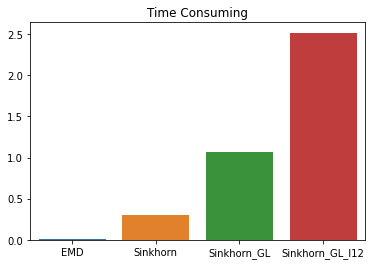

In [6]:
pl.title('Time Consuming')
sns.barplot(y=[np.mean(t1), np.mean(t2), np.mean(t3), np.mean(t4)], x=['EMD', 'Sinkhorn', 'Sinkhorn_GL', 'Sinkhorn_GL_l12'])

## Fig 1 : plots source and target samples



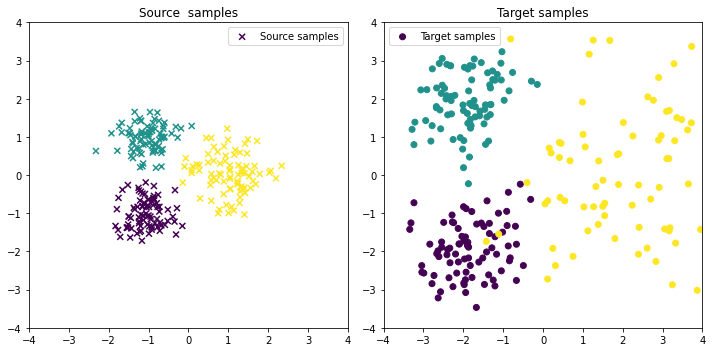

In [7]:
pl.figure(1, figsize=(10, 5))
pl.subplot(1, 2, 1)
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='x', label='Source samples')
# pl.xticks([])
# pl.yticks([])
pl.xlim(-4,4)
pl.ylim(-4,4)

pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(1, 2, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
pl.xlim(-4,4)
pl.ylim(-4,4)

pl.legend(loc=0)
pl.title('Target samples')
pl.tight_layout()

(-4.0, 4.0)

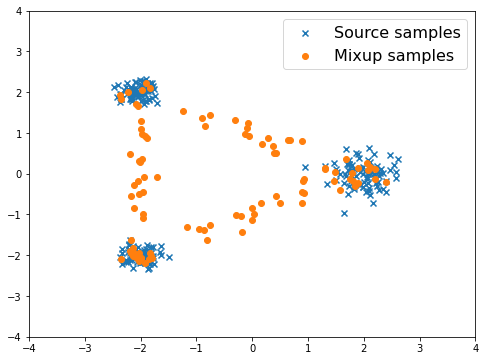

In [68]:
np.random.seed(123456)

Xt, yt = ot.datasets.make_data_classif('3gauss2', n_target_samples, nz=0.15)

randidx_a = np.random.randint(0, 250, 100)
randidx_b = np.random.randint(0, 250, 100)

a_X = Xt[randidx_a]
b_X = Xt[randidx_b]
a_ys = ys[randidx_a]
b_ys = ys[randidx_b]

c_ys =[]

label2idx = {'%d'%i: i for i in range(1, 4)}
idx = 3

for i in range(1, 4):
    for j in range(1, 4):
        if i==j:
            label2idx['%d_%d'%(i,j)] = label2idx['%d'%i]
        else:
            label2idx['%d_%d'%(i,j)] = idx
            idx += 1         

c_ys = [label2idx['%d_%d'%(i,j)] for i,j in zip(a_ys, b_ys)]
    
    
lamda = np.random.beta(2.0, 2.0, 100).reshape(100,1) #* 0.2 + 0.4
mixups = a_X * lamda + b_X * (1-lamda)
addups = a_X * -lamda + b_X * (1+lamda)

pl.figure(1, figsize=(8, 6))
plot_range = [-4, 4]

# pl.subplot(1,2,1)
pl.scatter(Xt[:, 0], Xt[:, 1],  marker='x', label='Source samples')
pl.scatter(mixups[:, 0], mixups[:, 1], marker='o', label='Mixup samples')
pl.legend(['Source samples', 'Mixup samples', '3'], fontsize=16)
pl.xlim(plot_range)
pl.ylim(plot_range)


# pl.subplot(1,2,2)
# pl.scatter(Xt[:, 0], Xt[:, 1], c=ys, marker='x', label='Source samples')
# pl.scatter(addups[:, 0], addups[:, 1], c=c_ys, marker='o', label='Addup samples')
# pl.legend(['1', '2', '3'])
# pl.xlim(plot_range)
# pl.ylim(plot_range)

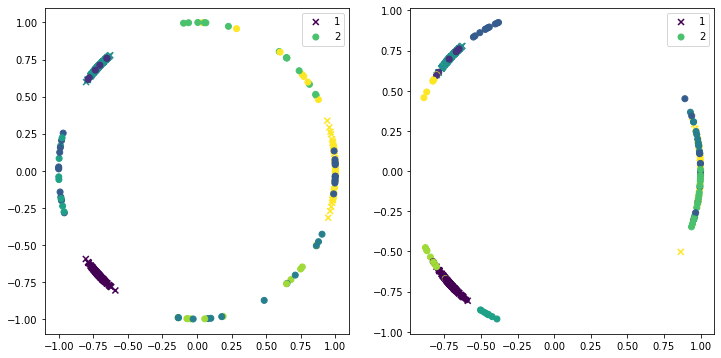

In [58]:
np.random.seed(123456)

Xt, yt = ot.datasets.make_data_classif('3gauss2', n_target_samples, nz=0.15)
Xt = Xt/np.linalg.norm(Xt, axis=1).reshape(-1, 1)


randidx_a = np.random.randint(0, 250, 100)
randidx_b = np.random.randint(0, 250, 100)

a_X = Xt[randidx_a]
b_X = Xt[randidx_b]
a_ys = ys[randidx_a]
b_ys = ys[randidx_b]

c_ys =[]

label2idx = {'%d'%i: i for i in range(1, 4)}
idx = 3

for i in range(1, 4):
    for j in range(1, 4):
        if i==j:
            label2idx['%d_%d'%(i,j)] = label2idx['%d'%i]
        else:
            label2idx['%d_%d'%(i,j)] = idx
            idx += 1         

c_ys = [label2idx['%d_%d'%(i,j)] for i,j in zip(a_ys, b_ys)]
    
    
lamda = np.random.beta(0.2, 0.2, 100).reshape(100,1) * 0.2 + 0.4
mixups = a_X * lamda + b_X * (1-lamda)
addups = a_X * -lamda + b_X * (1+lamda)

mixups = mixups/ np.linalg.norm(mixups, axis=1).reshape(-1, 1)
addups = addups/ np.linalg.norm(addups, axis=1).reshape(-1, 1)

pl.figure(1, figsize=(12, 6))

pl.subplot(1,2,1)
pl.scatter(Xt[:, 0], Xt[:, 1], c=ys, marker='x', label='Source samples')
pl.scatter(mixups[:, 0], mixups[:, 1], c=c_ys, marker='o', label='Mixup samples')
pl.legend(['1', '2', '3'])

pl.subplot(1,2,2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=ys, marker='x', label='Source samples')
pl.scatter(addups[:, 0], addups[:, 1], c=c_ys, marker='o', label='Addup samples')
pl.legend(['1', '2', '3'])

In [ ]:
pl.figure(1, figsize=(12, 6))

Xt_norm = 
pl.subplot(1,2,1)
pl.scatter(Xt[:, 0], Xt[:, 1], c=ys, marker='x', label='Source samples')
pl.scatter(mixups[:, 0], mixups[:, 1], c=c_ys, marker='o', label='Mixup samples')
pl.legend(['1', '2', '3'])

pl.subplot(1,2,2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=ys, marker='x', label='Source samples')
pl.scatter(addups[:, 0], addups[:, 1], c=c_ys, marker='o', label='Addup samples')
pl.legend(['1', '2', '3'])

## Fig 2 : plot optimal couplings and transported samples



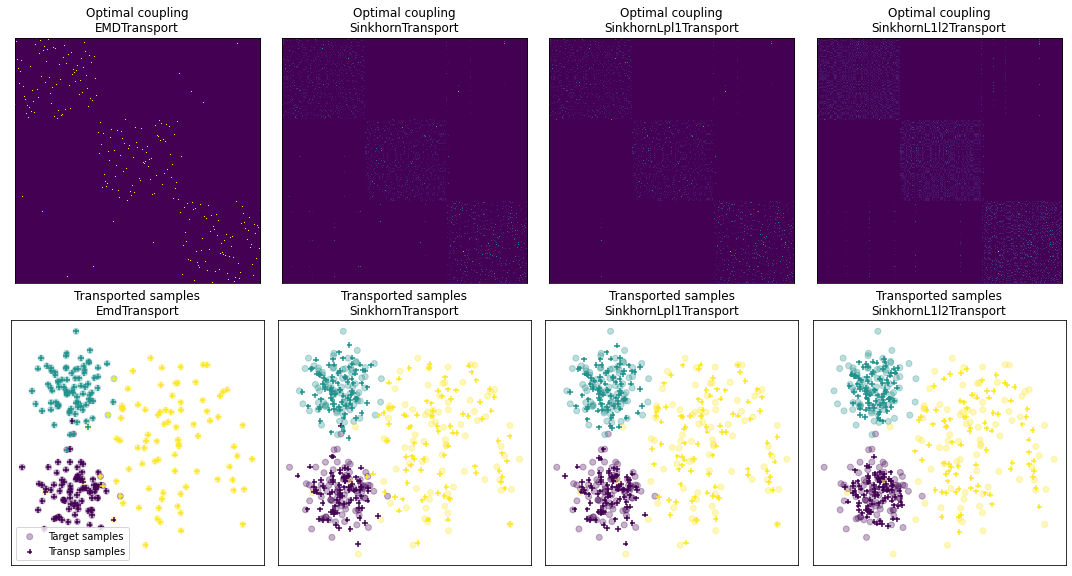

In [50]:
param_img = {'interpolation': 'nearest'}

pl.figure(2, figsize=(15, 8))
pl.subplot(2, 4, 1)
pl.imshow(ot_emd.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nEMDTransport')

pl.subplot(2, 4, 2)
pl.imshow(ot_sinkhorn.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornTransport')

pl.subplot(2, 4, 3)
pl.imshow(ot_lpl1.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornLpl1Transport')

pl.subplot(2, 4, 4)
pl.imshow(ot_l1l2.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornL1l2Transport')

pl.subplot(2, 4, 5)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nEmdTransport')
pl.legend(loc="lower left")

pl.subplot(2, 4, 6)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornTransport')

pl.subplot(2, 4, 7)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornLpl1Transport')

pl.subplot(2, 4, 8)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_l1l2[:, 0], transp_Xs_l1l2[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornL1l2Transport')
pl.tight_layout()

pl.show()